# Train and detect

## Load coco

In [1]:
from pycocotools.coco import COCO

# Path to load the COCO annotation file
annotation_file = 'data/resize_blur10/train/annotation_coco.json'

# Initialise the COCO object
coco = COCO(annotation_file)

# Get all category tags and corresponding category IDs
categories = coco.loadCats(coco.getCatIds())
category_id_to_name = {cat['id']: cat['name'] for cat in categories}

# Print all category IDs and corresponding category names
for category_id, category_name in category_id_to_name.items():
    print(f"Category ID: {category_id}, Category Name: {category_name}")

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
Category ID: 1, Category Name: grape_berry


## Modify config

In [2]:
from mmengine import Config
cfg = Config.fromfile('../configs/mask_rcnn/mask-rcnn_r50-caffe_fpn_ms-poly-1x_coco.py')

In [3]:
from mmengine.runner import set_random_seed

# Modify dataset classes and color
cfg.metainfo = {
    'classes': ('grape_berry', ),
    'palette': [
        (220, 20, 60),
    ]
}

# Modify dataset type and path
# 使用する学習データのパスを指定
cfg.data_root = './data/resize_blur10'

cfg.train_dataloader.dataset.ann_file = 'train/annotation_coco.json'
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix.img = 'train/color'
cfg.train_dataloader.dataset.metainfo = cfg.metainfo

cfg.val_dataloader.dataset.ann_file = 'val/annotation_coco.json'
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix.img = 'val/color/'
cfg.val_dataloader.dataset.metainfo = cfg.metainfo

cfg.test_dataloader = cfg.val_dataloader

# Modify metric config
cfg.val_evaluator.ann_file = cfg.data_root+'/'+'val/annotation_coco.json'
cfg.test_evaluator = cfg.val_evaluator

# Modify num classes of the model in box head and mask head
cfg.model.roi_head.bbox_head.num_classes = 1
cfg.model.roi_head.mask_head.num_classes = 1

# We can still the pre-trained Mask RCNN model to obtain a higher performance
cfg.load_from = '../checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './tutorial_exps'


# We can set the evaluation interval to reduce the evaluation times
cfg.train_cfg.val_interval = 3
# We can set the checkpoint saving interval to reduce the storage cost
cfg.default_hooks.checkpoint.interval = 3

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optim_wrapper.optimizer.lr = 0.02 / 8
cfg.default_hooks.logger.interval = 10


# Set seed thus the results are more reproducible
# cfg.seed = 0
set_random_seed(0, deterministic=False)

# We can also use tensorboard to log the training process
cfg.visualizer.vis_backends.append({"type":'TensorboardVisBackend'})

#------------------------------------------------------
config=f'../configs/mask_rcnn/mask-rcnn_r50-caffe_fpn_ms-poly-3x_coco.py'
with open(config, 'w') as f:
    f.write(cfg.pretty_text)

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Train a new detector

Finally, lets initialize the dataset and detector, then train a new detector!

In [4]:
!python ../tools/train.py {config}

04/17 06:54:44 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.7.10 (default, Feb 26 2021, 18:47:35) [GCC 7.3.0]
    CUDA available: False
    MUSA available: False
    numpy_random_seed: 1472541832
    GCC: gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
    PyTorch: 1.9.0
    PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) oneAPI Math Kernel Library Version 2021.2-Product Build 20210312 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.1.2 (Git Hash 98be7e8afa711dc9b66c8ff3504129cb82013cdb)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - Build settings: BLAS_INFO=mkl, BUILD_TYPE=Release, CUDA_VERSION=11.1, CUDNN_VERSION=8.0.5, CXX_COMPILER=/opt/rh/devtoolset-7/root/usr/bin/c++, CXX_FLAGS= -Wno-deprecated -fvisibility-inlines-hidden -DUSE_PTHREADPOOL -fopenmp -DNDEBUG -DUSE_KINETO -DUSE_FBGEMM

### Load tensorboard

In [5]:
%load_ext tensorboard

In [6]:
%tensorboard --logdir tutorial_exps/

## Test the Trained Detector

After finetuning the detector, let's visualize the prediction results!

In [12]:
pwd

'/mmdetection-grape/grape'

In [20]:
import mmcv
from mmdet.apis import init_detector, inference_detector
img = mmcv.imread('./raw_data/R0010110/frame0.jpg',channel_order='rgb')
checkpoint_file = 'tutorial_exps/epoch_12.pth'
model = init_detector(cfg, checkpoint_file, device='cpu')
new_result = inference_detector(model, img)
#print(new_result)

Loads checkpoint by local backend from path: tutorial_exps/epoch_12.pth


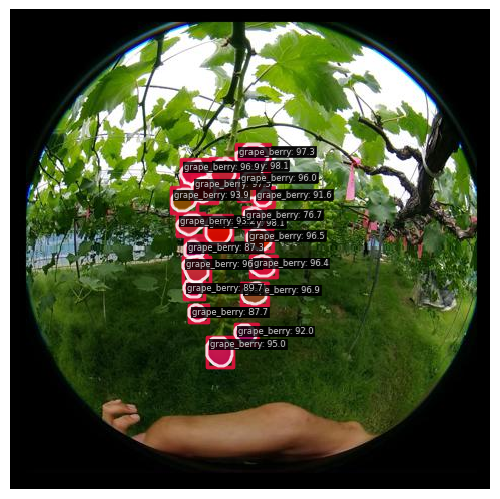

In [21]:
from mmengine.visualization import Visualizer
from mmdet.registry import VISUALIZERS
# get built visualizer
visualizer = VISUALIZERS.build(model.cfg.visualizer)
visualizer_now = Visualizer.get_current_instance()
# the dataset_meta is loaded from the checkpoint and
# then pass to the model in init_detector
visualizer_now.dataset_meta = model.dataset_meta
# show the results
visualizer_now.add_datasample(
    'new_result',
    img,
    data_sample=new_result,
    draw_gt=False,
    wait_time=0,
    out_file=None,
    pred_score_thr=0.5
)
visualizer_now.show()

In [16]:
import mmcv
from mmengine.visualization import Visualizer
from mmdet.registry import VISUALIZERS
from mmdet.apis import init_detector, inference_detector
import os

def show_result_pyplot(img_folder_path, output_folder_path):
    checkpoint_file = 'tutorial_exps/epoch_12.pth'
    model = init_detector(cfg, checkpoint_file, device='cpu')
    visualizer = VISUALIZERS.build(model.cfg.visualizer)
    visualizer.dataset_meta = model.dataset_meta
    for img_path in os.listdir(img_folder_path):
        img = mmcv.imread(img_folder_path + img_path, channel_order='rgb')
        new_result = inference_detector(model, img)
        visualizer.add_datasample(
            'new_result',
            img,
            data_sample=new_result,
            draw_gt=False,
            wait_time=0,
            out_file=f'{output_folder_path}/{img_path}',
            pred_score_thr=0.5
        )

In [19]:
image_folder = './raw_data/room_4k5/'
output_folder = './data/room_4k5_output/'
show_result_pyplot(image_folder, output_folder)

Loads checkpoint by local backend from path: tutorial_exps/epoch_12.pth


/opt/conda/lib/python3.7/site-packages/mmengine/visualization/visualizer.py:762: UserWarning: Warning: The bbox is out of bounds, the drawn bbox may not be in the image
  ' the drawn bbox may not be in the image', UserWarning)
/opt/conda/lib/python3.7/site-packages/mmengine/visualization/visualizer.py:833: UserWarning: Warning: The polygon is out of bounds, the drawn polygon may not be in the image
  ' the drawn polygon may not be in the image', UserWarning)
